In [1]:
# https://github.com/Grillard/GalfitPyWrap may be useful for setting up inputs
import sys
sys.path.insert(0,'/data/emiln/XLSSU122/analysis/galfit/GalfitPyWrap')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
from __future__ import division
import fnmatch
%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


### LOAD XLSSC122 DATA

4
33
13


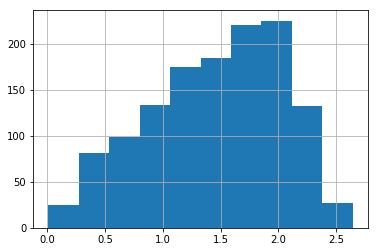

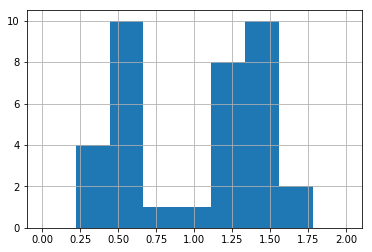

In [2]:
df = pd.read_csv('/data/emiln/XLSSU122/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat',delim_whitespace=True)
df['gold_cluster'] = 0
df['gold_foreground'] = 0
df['silver_cluster'] = 0
df.columns.values
df['(f140)kron'] = df['f140_kron']
for i,r in df.iterrows():
    if (r['member1']>0.5) and (r['(f140)kron']<24 or (r['(f140)kron']<24.5 and r['em-code']==1)):
#         print 'cluster mem'
        df.at[i,'gold_cluster'] = 1
    if (r['member1']<0.5 and r['member1']>0.1) and (r['(f140)kron']<24 or (r['(f140)kron']<24.5 and r['em-code']==1)):
#         print 'cluster mem'
        df.at[i,'silver_cluster'] = 1
    if (r['member2']>0.5) and (r['(f140)kron']<24 or (r['(f140)kron']<24.5 and r['em-code']==1)):
        df.at[i,'gold_foreground'] = 1  
print df['silver_cluster'].sum()
print df['gold_cluster'].sum()
print df['gold_foreground'].sum()
# Compute color for each cluster member
df['color'] = df['f105_0p8'] - df['f140_0p8']
# Compute r/r500 for each cluster member
# Cluster Center
cluster_ra = 34.434125
cluster_dec = -3.7587388
r500 = 35 # arcsec
df['r_center'] = np.sqrt((df['ra']-cluster_ra)**2 + (df['dec']-cluster_dec)**2)*3600./r500
df['r_center'].hist()
members1 = df[df['gold_cluster']==1]
members2 = df[df['gold_foreground']==1]
members1s = df[df['silver_cluster']==1]

members = df[(df['gold_cluster']==1) | (df['silver_cluster']==1)]
plt.show()
members['color'].hist(bins=np.linspace(0,2,10))

In [4]:
len(members)

37

Test matching between sextractor photometric and spec+phot catalogs

In [9]:
print len(df)
df
df1 = pd.read_csv('/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci.cat',skiprows=9,delim_whitespace=True,header=0,names=['ID','ra','dec','mag_auto','magerr_auto','mag_aper']+['g']*5+['magerr_aper']+['g']*5+['fwhm_world','flux_radius','flags'])
df1.columns.values

1301


array(['ID', 'ra', 'dec', 'mag_auto', 'magerr_auto', 'mag_aper', 'g',
       'g.1', 'g.2', 'g.3', 'g.4', 'magerr_aper', 'g.5', 'g.6', 'g.7',
       'g.8', 'g.9', 'fwhm_world', 'flux_radius', 'flags'], dtype=object)

In [17]:
df1.sort_values('flux_radius',ascending=False)

,ID,ra,dec,mag_auto,magerr_auto,mag_aper,g,g.1,g.2,g.3,g.4,magerr_aper,g.5,g.6,g.7,g.8,g.9,fwhm_world,flux_radius,flags
706,707,34.434095,-3.757657,20.3433,0.0200,24.8486,23.6471,23.1111,23.2496,22.7462,22.0012,0.1982,0.0973,0.0715,0.0779,0.0585,0.0408,0.000119,64.930,2
1188,1189,34.427029,-3.746344,19.4405,0.0131,27.2055,25.7989,25.0656,25.2691,24.5316,23.4939,0.6196,0.2825,0.1889,0.2108,0.1403,0.0905,0.001074,48.315,2
107,108,34.453914,-3.773580,19.2383,48.0165,23.6560,22.4031,21.7933,21.9617,21.3264,20.2486,0.2727,0.1308,0.0936,0.1021,0.0727,0.0426,0.000154,38.112,3
275,276,34.426485,-3.768487,20.7478,0.0243,25.9691,24.5910,23.8548,24.0617,23.2675,22.0573,0.3458,0.1572,0.1052,0.1192,0.0776,0.0427,0.000233,37.727,2
500,501,34.447755,-3.762263,19.9042,0.0163,24.2953,23.1352,22.6247,22.7602,22.2641,21.3123,0.1571,0.0781,0.0588,0.0637,0.0485,0.0307,0.000101,36.153,2
701,702,34.433961,-3.759269,20.7407,0.0234,25.9864,24.8721,24.3828,24.5125,24.0272,22.3244,0.3378,0.1737,0.1305,0.1413,0.1088,0.0495,0.000093,31.640,2
813,814,34.420950,-3.755625,22.4435,0.0632,28.0740,26.6250,25.9118,26.1107,25.3712,23.5606,0.9663,0.4027,0.2711,0.3023,0.2038,0.0924,0.000755,29.637,2
1276,1277,34.444969,-3.744896,21.8779,0.0413,26.1745,24.8687,24.2623,24.4185,23.8478,22.8430,0.3870,0.1831,0.1286,0.1393,0.1023,0.0655,0.000146,28.939,2
1135,1136,34.435917,-3.749537,20.9134,0.0256,25.4225,24.1222,23.5171,23.6808,23.0800,22.0072,0.2685,0.1240,0.0891,0.0978,0.0702,0.0429,0.000175,28.025,2
63,64,34.452903,-3.773438,18.8997,0.0230,24.3243,22.9516,22.2109,22.4215,21.6050,19.7570,0.3473,0.1572,0.1055,0.1187,0.0760,0.0320,0.000514,27.606,2


In [13]:
mdf = df.merge(df1,left_on='spec-id',right_on='ID',how='inner',suffixes=["","_pc"])

In [14]:
mdf
mdf[['ra','ra_pc','dec','dec_pc']]

,ra,ra_pc,dec,dec_pc
0,34.418431,34.457761,-3.752946,-3.760857
1,34.447945,34.421964,-3.757976,-3.761834
2,34.449888,34.445913,-3.770144,-3.773490
3,34.436443,34.443347,-3.739387,-3.745001
4,34.426333,34.427223,-3.746769,-3.750174
5,34.445383,34.417155,-3.763075,-3.766008
6,34.433709,34.442501,-3.767768,-3.770088
7,34.423811,34.456944,-3.756163,-3.761326
8,34.452048,34.441241,-3.767600,-3.771883
9,34.445601,34.415976,-3.745351,-3.751375


### Make source cutouts

In [5]:
hst_file = '/data/emiln/XLSSU122/xlssuj0217-0345-f140w_drz_sci.fits'
hst_hdulist = fits.open(hst_file)
full_wcs = wcs.WCS(hst_hdulist[0].header)

In [7]:
# For each object in fhst_df
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

import copy

# exptime=1900 # https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf
w=400
# df = cos_df[cos_df['NUMBER']==886]
# df = cos_df[0:2]
# df = cos_df
df = members

# df = cos_df
for idx, r in df.iterrows():
    print idx
    ra = r.ra
    dec = r.dec
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['phot-id'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    tdir = '/data/emiln/XLSSU122/analysis/XLSSC122/galfit_results/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = hst_hdulist[0].data[Y-w:Y+w,X-w:X+w]
#     expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
#     rmscut = rms_hdulist[0].data[Y-w:Y+w,X-w:X+w]
#     whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w] # inverse variance
#     rmscut = np.sqrt(1./whtcut) # stdev per pixel
#     print expcut.shape
    print datacut.shape
#     print rmscut.shape
#     print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s
#     newexp = expcut
#     newrms = rmscut # this is in ELECTRONS/s
#     newwht = whtcut
#     newcounts = newdata * expcut 
#     newcounts2 = newdata * expcut / 2.5 # Should divide by the gain = 2.5 (e/count) to get this in counts
    
#     central_mask = np.zeros(newdata.shape)
#     xx, yy = np.meshgrid(np.arange(central_mask.shape[0]),np.arange(central_mask.shape[1]))
#     xc = newdata.shape[0]/2
#     yc = newdata.shape[1]/2
#     rthresh = r.FLUX_RADIUS_1_F125W # Mask out inner 20% light radius
#     central_mask_IDs = (xx-xc)**2+(yy-yc)**2 < rthresh**2
#     central_mask[central_mask_IDs] = 1
    
#     nonzero_counts = newcounts.copy()
#     nonzero_counts[nonzero_counts<0] = 0
    
#     nonzero_counts2 = newcounts2.copy()
#     nonzero_counts2[nonzero_counts2<0] = 0
    
#     newcounts_meanexp = newdata * np.mean(expcut)
#     nonzero_counts_meanexp = newcounts_meanexp.copy()
#     nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0
#     print np.min(nonzero_counts)
    
#     newcounts_meanexp2 = newdata * np.mean(expcut) / 2.5
#     nonzero_counts_meanexp2 = newcounts_meanexp2.copy()
#     nonzero_counts_meanexp2[nonzero_counts_meanexp2<0] = 0
    
#     newsigma = (np.sqrt(1./rmscut) + np.sqrt(nonzero_counts))/expcut
#     newsigma_meanexp = (np.sqrt(1./rmscut) + np.sqrt(nonzero_counts_meanexp))/np.mean(expcut)
#     newsigma_counts = np.sqrt(rmscut * np.mean(expcut)) / 2.5 + np.sqrt(nonzero_counts_meanexp2)
    
    # RMS + POISSON
#     newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)
#     newsigma_counts = np.sqrt(rmscut * np.mean(expcut)) / 2.5 + np.sqrt(nonzero_counts_meanexp2)
    
#     newsigma = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts))/expcut
#     newsigma_meanexp = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts_meanexp))/np.mean(expcut)
#     newsigma_counts = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts)) / 2.5

    
#     new_cos_hdu = fits.PrimaryHDU(newdata)
#     new_cos_hdul = fits.HDUList([new_cos_hdu])
#     new_cos_hdul[0].header = cos_hdulist[0].header
#     new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_cos_filename = tdir+'/cutout.fits'
#     new_cos_hdul.writeto(new_cos_filename, clobber=True)

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = hst_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    

26
[array(2197.56319443), array(2196.52377215)]
ID 529
RA: 34.434215
DEC: -3.758796
Initial X: 2197
Initial Y: 2196
Directory already exists.
(800, 800)


40
[array(2911.99895553), array(1913.49833046)]
ID 455
RA: 34.422282
DEC: -3.7635129999999997
Initial X: 2911
Initial Y: 1913
Directory already exists.
(800, 800)
53
[array(2204.68789793), array(2264.80376615)]
ID 661
RA: 34.434096000000004
DEC: -3.757658
Initial X: 2204
Initial Y: 2264
Directory already exists.
(800, 800)
57
[array(2303.23688037), array(2728.84358876)]
ID 1036
RA: 34.43245
DEC: -3.7499239999999996
Initial X: 2303
Initial Y: 2728
Directory already exists.
(800, 800)
59
[array(2148.70859814), array(1647.40378369)]
ID 300
RA: 34.435031
DEC: -3.7679480000000005
Initial X: 2148
Initial Y: 1647
Directory already exists.
(800, 800)
66
[array(2112.96528327), array(2535.70377129)]
ID 920
RA: 34.435628
DEC: -3.753143
Initial X: 2112
Initial Y: 2535
Directory already exists.
(800, 800)
75
[array(1422.9608133), array(1643.85862651)]
ID 305
RA: 34.447153
DEC: -3.768007
Initial X: 1422
Initial Y: 1643
Directory already exists.
(800, 800)
76
[array(2037.64675648), array(2713.9036576